# Computational Homework 10: Fun with the eigenvalue decomposition

## Part 1: The PageRank algorithm
In this homework assignment, we investigate the original ranking algorithm developed by Larry Page and Sergey Brin, the founders of Google, to rank web pages based on importance.

The basic setup of the algorithm is as follows: suppose a user searches for the term "linear algebra", and we find $N$ webpages containing a string match for this term. How do we determine which of these $N$ pages are most relevant? To solve this problem, the PageRank algorithm makes the following assumption: more important webpages are more likely to have other pages linking to it. 

We represent the stucture of interlinking webpages as a _graph_, i.e. an object consisting of $N$ vertices (webpages) and edges. There is an edge connecting vertex $i$ to vertex $j$ page $i$ links to page $j$. The structure of such a graph can be represented by an $N\times N$ _adjacency matrix_ $\boldsymbol{L}$ such that 

$$
L_{ij} = \begin{cases}1 & \text{if $j$ links to $i$}\\ 0 & \text{otherwise} \end{cases}
$$

(by default we always assume $L_{ii} = 0$). Consider the following simple example with four webpages.

In [9]:
# you need networkx installed to visualize the graphs
!pip install networkx

import numpy as np
import networkx as nx

The graph with adjacency matrix

[[0 0 1 0]
 [1 0 0 0]
 [1 1 0 1]
 [0 0 0 0]]

can be visualized as


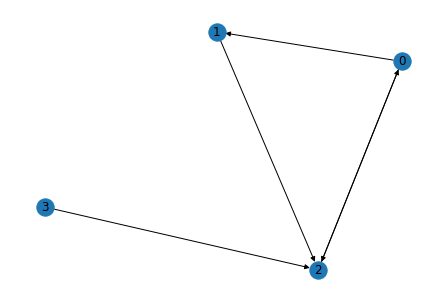

In [10]:
L = np.array([[0, 0, 1, 0], [1, 0, 0, 0], [1, 1, 0, 1], [0, 0, 0, 0]])
print('The graph with adjacency matrix')
print('')
print(L)
print('')
print('can be visualized as')

G = nx.from_numpy_matrix(L.T, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

Given a set of $N$ pages, the PageRank is a vector $\boldsymbol{p}\in \mathbb{R}^N$, such that $\boldsymbol{1}^\top \boldsymbol{p} = \sum_{i=1}^N p_i = N$, where here $\boldsymbol{1}$ is the all ones vector. The goal is to find $\boldsymbol{p}$ such that the most important pages have the largest entry in the PageRank vector. We can now describe the actual PageRank algorithm for finding $\boldsymbol{p}$.

The total number of output links from page $j$ is given by $d_j = \sum_{i=1}^N L_{ij}$. The PageRank algorithm defines the PageRanks as satisfying the following relation:

$$
p_i = (1-\alpha) + \alpha \sum_{j=1}^N \frac{L_{ij}}{d_j}p_j \;\;\;\;\;\; (1)
$$

Let's interpret what is happening in this equation. Inuitively, the component $\sum_{j=1}^N L_{ij}p_j/d_j$ says that the importance $p_i$ of page $i$ is given by the weighted sum of the importance of pages which link to it, where the weights are $L_{ij}/d_j$. This ensures that each page can distribute a total weight of 1 to other pages, since 

$$
\sum_{i=1}^N \frac{L_{ij}}{d_j} = \frac{\sum_{i=1}^n L_{ij}}{\sum_{i=1}^N L_{ij}} = 1.
$$
The scalar $\alpha$ (apparently set to 0.85 in the original implementation) is a weighting factor which governs how much influence the rank other pages have on the importance of page $i$. 

The PageRank algorithm describes an approach to find the ranking vector $\boldsymbol{p}$ satisfying $(1)$, by reducing the problem to an eigenvalue problem.

### Problem 1: exploiting matrix properties

Note that we can write the relation (1) in matrix form as

$$
\boldsymbol{p} = (1-\alpha)\boldsymbol{1} + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}\boldsymbol{p}
$$

where we define $\boldsymbol{D} = \text{diag}(d_1,\dots, d_N)$. Moreover, since we use the normalization $\boldsymbol{1^\top p} = N$, we can equivalently write this relation as 

$$
\begin{align*}
\boldsymbol{p} &= (1-\alpha)\boldsymbol{11^\top p}/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}\boldsymbol{p}\\
&= [(1-\alpha)\boldsymbol{11}^\top/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}] \boldsymbol{p}\\
&= \boldsymbol{Ap}
\end{align*}
$$

where we defined the $N\times N$ matrix $\boldsymbol{A} = (1-\alpha)\boldsymbol{11}^\top/N + \alpha \boldsymbol{L}\boldsymbol{D}^{-1}$. 

Now we arrive at something that should look familiar: $\boldsymbol{Ap} = \boldsymbol{p}$. This says that the PageRank vector $\boldsymbol{p}$ should be an _eigenvector_ of the matrix $\boldsymbol{A}$ associated with the eigenvalue 1.

It turns out we can actually prove that the matrix $\boldsymbol{A}$ defined above always has an eigenvalue of 1. However, let's verify that this is true. Using the simple adjacency matrix $\boldsymbol{L}$ defined at the beginning of the notebook, construct the matrix $\boldsymbol{A}$ and find its eigenvalues. Verify that one of the eigenvalues is equal to 1, and find the eigenvector $\boldsymbol{p}$ associated with this eigenvalue, and rescale the vector so that it sums to $N$ (i.e. multiply by $N/\boldsymbol{1^\top p}$). For the simple linked "webpages" described by the graph at the beginning of this notebook, which page is ranked the highest? Describe why the makes sense given what we can see visually about the graph.

### Problem 2: the power method for large graphs

When you we only have a few webpages, like in the toy graph presented earlier, computing a full eigenvalue decomposition is a completely reasonable way to solve the PageRank problem. However, realistic web searches will of course involve *many* more pages than this (for example, if you Google "linear algebra" you will find 150,000,000+ results). In this case, it is not feasible to compute a full eigenvalue decomposition for $\boldsymbol{A}$ defined in Part 2. Instead, the PageRank algorithm uses something called the _power method_ to find the top eigenvector (which will always be associated with the eigenvalue 1) of the matrix $\boldsymbol{A}$.

To do this, we initialize $\boldsymbol{p}^{(0)} = (1,\dots, 1)$, and perform the following iterations for $t=1,\dots, T$:

$$
\tilde{\boldsymbol{p}}^{(t+1)} = \boldsymbol{A}\boldsymbol{p}^{(t)},\;\;\; \boldsymbol{p}^{(t+1)} = N\frac{\tilde{\boldsymbol{p}}}{\boldsymbol{1}^\top \tilde{\boldsymbol{p}}^{(t+1)}}
$$

Implement the power iterations for $T=10$ steps defined above for the following randomly generated adjacency matrix. Verify that the vector $\boldsymbol{p}^{(T)}$ that you get at the end is an eigenvector of the matrix $\boldsymbol{A}$ -- i.e. that $\boldsymbol{A}\boldsymbol{p}^{(T)}$ is just a rescaled version of $\boldsymbol{p}^{(T)}$ (hint: to do this, you can check that $\boldsymbol{Ap}/\boldsymbol{p}$ is a constant vector).

In [2]:
import numpy as np 

N = 1000

# randomly generate an N x N adjacency matrix
L = np.random.binomial(1, 0.3, size=(N,N))

# make sure all the diagonal entries are equal to zero
np.fill_diagonal(L, 0)

L

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Part 2: Latent semantic indexing

Suppose we had a corpus of $D$ documents (e.g. webpages) of text which we would like to group into "topics", but that we don't a priori know what these topics should be. This problem is generally known as _topic modeling_. Latent semantic indexing (LSI) (sometimes called latent semantic analysis (LSA)) is a simple and popular approach to topic modeling that relies on a term-document matrix associated with the collection of documents.

In the context of text analysis, a _term_ typically refers to an individuals word. Let's say in our corpus of $D$ documents that there are $T$ distinct terms (and for the sake of this example, assume that $T > D$, so there are more words than documents). Then the term-document matrix is the matrix $\boldsymbol{M}$ such that

$$
M_{ij} = \text{ number of times term $i$ appears in document $j$}.
$$

Since we assume $T>D$, this will be a "tall" matrix. Note that row $i$, denoted $\boldsymbol{t}_i$ and of length $n$, represents how word $i$ is distributed across the documents, while column $j$, denoted $\boldsymbol{d}_j$ and of length $m$, represents the distribution of words present in document $j$. Correspondingly, $\boldsymbol{t}_i^\top \boldsymbol{t}_{i'}$ represents a measure of similarity between terms $i$ and $i'$, in terms of how they appear in documents. Similarly for $\boldsymbol{d}_j^\top \boldsymbol{d}_{j'}$ and the similarity between documents $j$ and $j'$, in terms of which terms appear in them. These two types of similarity can be calculated using the matrices 

$$
\begin{align*}
&\underbrace{\boldsymbol{MM}^\top}_{T\times T} \hspace{10mm} \text{containing all the pairwise similarities between terms, and}\\
&\underbrace{\boldsymbol{M^\top M}}_{D\times D} \hspace{10mm} \text{containing all the pairwise similarities between documents}
\end{align*}
$$

Similar to the covariance matrices in PCA, we can take an eigenvalue decomposition of either of these matrices, as they will be symmetric and positive semi-definite. Doing so is precisely what LSA entails, as we will see in the following problems.

### Problem 1: extracting document-topic scores
Let's focus on what this means for the matrix $\boldsymbol{M^\top M}$ of documents similarities. In this case, we get the eigenvalue decomposition

$$
\boldsymbol{M^\top M} = \boldsymbol{V\Lambda V^\top}
$$

Like in PCA, the columns in $\boldsymbol{V}$ represent the most informative "directions" along which various documents can be similar. We can interpret the top $k\leq D$ of these directions as representing individual "topics". That is, if we extract the first $k$ vectors stored in the columns of $\boldsymbol{V}$, we can get a $D\times k$ _document-topic_ matrix $\boldsymbol{V}_k$. For document $j$, the entries in the $j^{th}$ row of this matrix represent how much document $j$ aligns with each topic. 

In this problem, we will extract these scores for a very simple set of documents, defined in the cell below.

In [26]:
corpus = [
    "the person went to the store to buy an apple",
    "the woman can buy a car at the store",
    "you eat an apple every morning",
    "the car wash is closed on sunday",
    "i drive my car on sunday morning"
]

The python package `scikit-learn` has a useful function which will allow us to extract a term-document matrix from this corpus. Note that $\boldsymbol{M}$ here is $26\times 5$, as our corpus contains 26 "documents" and 5 word; each row corresponds to a different word, each column to a different document.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
 
vectorizer = CountVectorizer()
M = vectorizer.fit_transform(corpus).toarray().T
print(M.shape) # 26 words, 5 documents
M

(23, 5)


array([[1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1],
       [2, 2, 0, 1, 0],
       [2, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

Compute an eigenvalue decomposition of $\boldsymbol{M^\top M}$, and plot its eigenvalues from largest to smallest. Then, get the document-topic matrix $\boldsymbol{V}_k$ (containing the top $k$ columns of $\boldsymbol{V}$, correspoding to the largest $k$ eigenvalues). Do this for $k=3$, and interpret the results.

### Problem 2: extracting the word-topic matrix

Instead of finding which words are associated with which topic, we could instead try and find which words are most associated with each topic. To do this, we instead need an eigenvalue decomposition of the term similarity matrix: 
$$
\boldsymbol{MM^\top} = \boldsymbol{U\Lambda' U^\top}
$$ 

Now $\boldsymbol{U}$ is a $T\times T$ matrix. If we select the top $k$ columns from this matrix, we can get scores that indicate the "alignment" of each word against each of the $k$ topics. Do the following:

1. Compute the eigenvalue decomposition of $\boldsymbol{MM^\top}$, and verify that the eigenvalues of $\boldsymbol{\Lambda}'$ are closely related to those of $\boldsymbol{\Lambda}$ in problem 1.
2. Construct the word-topic matrix $\boldsymbol{U}_k$ by selecting the top $k=3$ columns of $\boldsymbol{U}$ (associated with the $k$ largest eigenvalues). Which words are most associated with topic 2? Why does this makes sense in the document-topic scores you saw in problem 1?

**An important remark:** Selecting $k$ topics using the topic matrix $\boldsymbol{MM^\top}$ or the document matrix $\boldsymbol{M^\top M}$ actually describe the same latent "topics". This is because the eigenvalue decompositions of these two matrices can be simplified into a single _singular value decomposition_, wherein $\boldsymbol{M} = \boldsymbol{U\Sigma V}^\top$ where $\boldsymbol{U},\boldsymbol{V}$ are as in the eigenvalues decompositions we discussed, and $\boldsymbol{\Sigma}$ is matrix containing the singular values of $\boldsymbol{M}$.
